In [1]:
import logging

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoConfig, RobertaForQuestionAnswering, squad_convert_examples_to_features
from transformers.data.processors.squad import SquadV2Processor

# Create logger
logger = logging.getLogger(__name__)

In [2]:
torch.__version__

'1.9.0+cu111'

In [3]:
# Check that cuda is available
torch.cuda.is_available()

True

In [4]:
%mkdir -p squad_data model_weights

In [5]:
%ls

 Homework_1_⚡️.ipynb  '(results).py'      train-step-losses.csv
 model_weights/        squad_data/
 prediction_outputs/   train_dataset.pt


In [6]:
!wget -P squad_data https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -P squad_data https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2023-02-15 09:28:21--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 2606:50c0:8000::153, 2606:50c0:8003::153, 2606:50c0:8002::153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|2606:50c0:8000::153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad_data/train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  26.3MB/s    in 1.5s    

2023-02-15 09:28:24 (26.3 MB/s) - ‘squad_data/train-v2.0.json’ saved [42123633/42123633]

--2023-02-15 09:28:25--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 2606:50c0:8000::153, 2606:50c0:8003::153, 2606:50c0:8002::153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|2606:50c0:8000::153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/

In [7]:
%ls squad_data

dev-v2.0.json  train-v2.0.json


In [8]:
# Configure the tokenizer and model
config = AutoConfig.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('roberta-base', do_lower_case=True, use_fast=False)
model = AutoModelForQuestionAnswering.from_pretrained('roberta-base', config=config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

In [9]:
def load_examples(data_dir, data_file, tokenizer, evaluate=False, output_examples=False):
    processor = SquadV2Processor()
    if evaluate:
        examples = processor.get_dev_examples(data_dir, filename=data_file)
    else:
        examples = processor.get_train_examples(data_dir, filename=data_file)

    features, dataset = squad_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        max_seq_length=384,
        doc_stride=128,
        max_query_length=64,
        is_training=not evaluate,
        return_dataset="pt",
        threads=1,
    )

    if output_examples:
        return dataset, examples, features

    return dataset

def train_single_epoch(data_loader, model, optimizer, device):
    """
    Function that runs a pytorch based training. For the model training
    with question and answering we will need the input_ids,
    attention mask, start and ending positions
    """
    # TODO: Set up loss meter
    # TODO: Get working with GPU
    step_losses = []

    # Put model in training mode
    model.train()

    # Description of training
    tqdm_loop = tqdm.tqdm(data_loader, leave=True)

    for data in tqdm_loop:
        # Zero out the gradients from the optimizer
        optimizer.zero_grad()

        # Get all of the outputs - for this function
        # it is specific to the question and answer inputs
        input_ids = data[0].to(device)
        attention_mask = data[1].to(device)
        start_positions = data[3].to(device)
        end_positions = data[4].to(device)

        # Get the outputs of the model - remember that
        # at least with the QA models the first output of the
        # model will be the loss
        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions,
        )

        # Gather the loss
        loss = outputs.loss
        step_losses.append(loss)

        # Calculate the gradients in the backward pass
        loss.backward()

        # update the gradients with the optimizer
        optimizer.step()

        # tqdm description
        tqdm_loop.set_postfix(loss=loss.item())

    return step_losses

In [10]:
# Create path variables
data_dir = 'squad_data'
train_data_file = 'train-v2.0.json'
validation_data_file = 'dev-v2.0.json'
create_training_data = False

# Create the training dataset
if create_training_data:
    train_dataset = load_examples(
        data_dir=data_dir,
        data_file=train_data_file,
        tokenizer=tokenizer,
        evaluate=False,
        output_examples=False,
    )
    torch.save(train_dataset, 'train_dataset.pt')
else:
    train_dataset = torch.load('train_dataset.pt')

# Create the validation set
validation_dataset, validation_examples, validation_features = load_examples(
    data_dir=data_dir,
    data_file=validation_data_file,
    tokenizer=tokenizer,
    evaluate=True,
    output_examples=True,
)

100%|███████████████████████████████████████████| 35/35 [00:03<00:00, 10.88it/s]
convert squad examples to features: 100%|█| 11873/11873 [00:54<00:00, 219.34it/s
add example index and unique id: 100%|█| 11873/11873 [00:00<00:00, 518841.97it/s


In [11]:
training_dataset = train_dataset[:(len(train_dataset) - 10000)]
test_dataset = train_dataset[(len(train_dataset) - 10000):]

In [12]:
class SquadDataset(Dataset):
    """
    Class that builds the encodings for the tokens
    from the Squad V2 dataset
    """

    def __init__(self, data, mode="training"):  # noqa
        self.data = data
        self.input_ids = data[0].tolist()
        self.attention_mask = data[1].tolist()
        self.mode = mode

        # If mode is training then we need to extract
        # the start and stop positions
        if self.mode == "training":
            # Add the start and end positions
            self.start_positions = data[3].tolist()
            self.end_positions = data[4].tolist()

    def __len__(self):  # noqa
        return len(self.input_ids)

    def __getitem__(self, idx):  # noqa
        # We need to get the outputs for all of the texts
        # Contexts
        # Set up input ids to be torch tensors
        input_ids = torch.tensor(self.input_ids[idx], dtype=torch.long)
        attention_mask = torch.tensor(self.attention_mask[idx], dtype=torch.long)

        # Gather outputs
        outputs = {"input_ids": input_ids, "attention_mask": attention_mask}

        if self.mode == "training":
            start_positions = torch.tensor(self.start_positions[idx], dtype=torch.long)
            end_positions = torch.tensor(self.end_positions[idx], dtype=torch.long)

            outputs["start_positions"] = start_positions
            outputs["end_positions"] = end_positions

        return outputs

In [13]:
training_dataset = SquadDataset(training_dataset, mode='training')
test_dataset = SquadDataset(test_dataset, mode='training')

In [14]:
train_loader = DataLoader(training_dataset, batch_size=16)

In [15]:
next(iter(train_loader))

{'input_ids': tensor([[   0, 1779,  222,  ...,    1,    1,    1],
         [   0, 2264,  911,  ...,    1,    1,    1],
         [   0, 1779,  222,  ...,    1,    1,    1],
         ...,
         [   0, 2264,   21,  ...,    1,    1,    1],
         [   0, 2264,   21,  ...,    1,    1,    1],
         [   0, 4993,   69,  ...,    1,    1,    1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'start_positions': tensor([ 84,  77, 154,  69,  87, 103, 144, 109,  86,  93, 148, 150, 166,  93,
         147,  70]),
 'end_positions': tensor([ 88,  79, 154,  72,  89, 106, 147, 113,  88,  94, 151, 150, 166,  94,
         150,  71])}

In [16]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [17]:
torch.cuda.device_count()

2

In [18]:
batch_size = 16
path = "./model_weights/text-mining-titans-roberta-qa.pt"

# Set up the device
device = (
    torch.device("cuda:0")
    if torch.cuda.is_available()
    else torch.device("cpu")  # noqa
)  # noqa

print(device)

cuda:0


In [19]:
next(model.parameters()).is_cuda

False

In [20]:
from transformers import TrainingArguments, Trainer
import math
import time

In [21]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self,
        batch_size=None,
        args=None,
        resume_from_checkpoint=None,
        trial=None,
        ignore_keys_for_eval=None
    ):
        # The first thing we will do just like the training inner loop is get the
        # training dataloader
        start = time.time()
        train_loader = self.get_train_dataloader()
        eval_loader = self.get_eval_dataloader()

        # Get number of epochs and max steps
        number_of_epochs = args.num_train_epochs
        max_steps = math.ceil(args.num_train_epochs * len(train_loader))

        # In our case we will set our own optimizer internally
        self.optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

        # Implement a learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)

        train_step_losses = []
        # Train the model over epochs
        for epoch in range(number_of_epochs):
            path = f"./model_weights/text-mining-titans-roberta-qa-cp{epoch}.pt"
            model.train()
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0

#             with tqdm.tqdm(train_loader, unit='batch') as training_epoch:
#                 training_epoch.set_description(f'Training epoch {epoch}')
            for step, data in enumerate(train_loader):
                # Zero out the optimizer
                self.optimizer.zero_grad()

                # Set up the inputs
                input_ids = data['input_ids'].to(args.device)
                attention_mask = data['attention_mask'].to(args.device)
                start_positions = data['start_positions'].to(args.device)
                end_positions = data['end_positions'].to(args.device)

                # Get the outputs of the model
                outputs = model(
                    input_ids,
                    attention_mask=attention_mask,
                    start_positions=start_positions,
                    end_positions=end_positions,
                )

                # Get the loss
                loss = outputs.loss

                # Make the backward pass and compute the gradients
                loss.backward()

                # Apply gradients
                self.optimizer.step()

#                 # Set loss description
#                 training_epoch.set_postfix(loss=loss.item())

                # Update the training loss per epoch
                train_loss_per_epoch += loss.item()
                train_step_losses.append(loss.item())
                    
            # Step with the scheduler after the epoch
            self.scheduler.step()
            train_loss_per_epoch /= len(train_loader)
            
            # Save the model
            torch.save(model.state_dict(), path)
            
            # Setup the evaluation process at the end of each epoch
            eval_loss_per_epoch = 0
            model.eval()
            with torch.no_grad():
#                 with tqdm.tqdm(eval_loader, unit='batch') as eval_epoch:
#                     eval_epoch.set_description(f'Evaluation Epoch {epoch}')
                    
                for eval_step, eval_data in enumerate(eval_loader):
                    input_ids = eval_data['input_ids'].to(args.device)
                    attention_mask = eval_data['attention_mask'].to(args.device)
                    start_positions = eval_data['start_positions'].to(args.device)
                    end_positions = eval_data['end_positions'].to(args.device)

                    # Get the outputs of the model
                    outputs = model(
                        input_ids,
                        attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions,
                    )

                    # Eval loss
                    eval_loss = outputs.loss
                    eval_loss_per_epoch += eval_loss.item()

                # compute the loss per epoch
                eval_loss_per_epoch /= len(eval_loader)
                    
                # Print the training and evaluation losses
                print(f'Train Loss: {train_loss_per_epoch}')
                print(f'Eval Loss: {eval_loss_per_epoch}')
        
        # Get the end time
        end = time.time()
        print(f'Time: {(end - start) / 60.0}')
        
        # Save train step losses
        train_step_losses = pd.Series(train_step_losses)
        train_step_losses.to_csv('train-step-losses.csv')

In [22]:
from transformers import DefaultDataCollator
import os
data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="model_weights",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Train Loss: 1.092692459291882
Eval Loss: 0.7974587857119739
Train Loss: 0.7103014185318924
Eval Loss: 0.7634216941788793
Train Loss: 0.5216155593415344
Eval Loss: 0.8480326493486762
Time: 180.44707897106807


In [23]:
from transformers.data.metrics.squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)
from transformers.data.processors.squad import SquadResult
import timeit

def evaluate(output_dir, model, tokenizer, device, datasets, prefix=""):
    batch_size = 4
    model_type = 'roberta'
    dataset, examples, features = datasets

    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=batch_size)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", batch_size)

    all_results = []
    start_time = timeit.default_timer()

    for batch in tqdm.tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
            }

            if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
                del inputs["token_type_ids"]

            feature_indices = batch[3]

            # Get the predicted outputs
            outputs = model(**inputs)

        for i, feature_index in enumerate(feature_indices):
            eval_feature = features[feature_index.item()]
            unique_id = int(eval_feature.unique_id)

            output = [to_list(output[i]) for output in outputs.to_tuple()]

            # Some models (XLNet, XLM) use 5 arguments for their predictions, while the other "simpler"
            # models only use two.
            if len(output) >= 5:
                start_logits = output[0]
                start_top_index = output[1]
                end_logits = output[2]
                end_top_index = output[3]
                cls_logits = output[4]

                result = SquadResult(
                    unique_id,
                    start_logits,
                    end_logits,
                    start_top_index=start_top_index,
                    end_top_index=end_top_index,
                    cls_logits=cls_logits,
                )

            else:
                start_logits, end_logits = output
                result = SquadResult(unique_id, start_logits, end_logits)

            all_results.append(result)

    evalTime = timeit.default_timer() - start_time
    logger.info("  Evaluation done in total %f secs (%f sec per example)", evalTime, evalTime / len(dataset))

    # Compute predictions
    output_prediction_file = os.path.join(output_dir, "predictions_{}.json".format(prefix))
    output_nbest_file = os.path.join(output_dir, "nbest_predictions_{}.json".format(prefix))
    output_null_log_odds_file = os.path.join(output_dir, "null_odds_{}.json".format(prefix))

    # TODO: Get defualt inputs for this function
    predictions = compute_predictions_logits(
        examples,
        features,
        all_results,
        n_best_size=20,
        max_answer_length=30,
        do_lower_case=True,
        output_prediction_file=output_prediction_file,
        output_nbest_file=output_nbest_file,
        output_null_log_odds_file=output_null_log_odds_file,
        verbose_logging=False,
        version_2_with_negative=True,
        null_score_diff_threshold=0.0,
        tokenizer=tokenizer,
      )

    # Compute the F1 and exact scores.
    results = squad_evaluate(examples, predictions)
    return results, examples, predictions

In [24]:
validation_datasets = (validation_dataset, validation_examples, validation_features)

In [25]:
%mkdir -p prediction_outputs
%ls

 Homework_1_⚡️.ipynb  '(results).py'      train-step-losses.csv
 model_weights/        squad_data/
 prediction_outputs/   train_dataset.pt


In [26]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [27]:
import timeit
import os
from torch.utils.data import SequentialSampler

results, examples, predictions = evaluate(
    output_dir='prediction_outputs',
    model=model,
    tokenizer=tokenizer,
    device=device,
    datasets=validation_datasets,
    prefix='final_evaluation'
)

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3062/3062 [02:02<00:00, 24.96it/s]
Writing predictions to: prediction_outputs/predictions_final_evaluation.json
Writing nbest to: prediction_outputs/nbest_predictions_final_evaluation.json
Writing null_log_odds to: prediction_outputs/null_odds_final_evaluation.json


In [28]:
results

OrderedDict([('exact', 76.77082455992588),
             ('f1', 80.39487190517924),
             ('total', 11873),
             ('HasAns_exact', 77.66531713900135),
             ('HasAns_f1', 84.92380467783306),
             ('HasAns_total', 5928),
             ('NoAns_exact', 75.87888982338099),
             ('NoAns_f1', 75.87888982338099),
             ('NoAns_total', 5945),
             ('best_exact', 76.77082455992588),
             ('best_exact_thresh', 0.0),
             ('best_f1', 80.39487190517916),
             ('best_f1_thresh', 0.0)])

In [29]:
losses = pd.read_csv('train-step-losses.csv')

<Axes: >

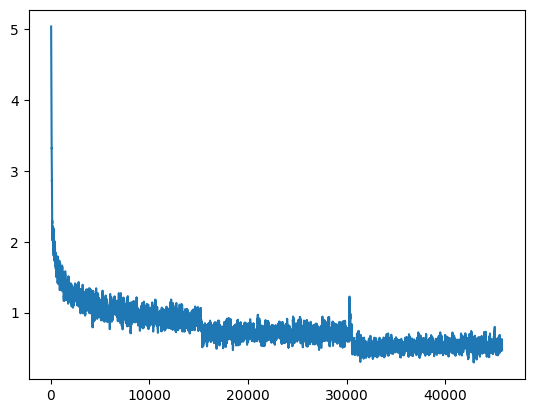

In [40]:
losses['0'].rolling(30).mean().dropna().plot()